In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time

torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
res_losses = []
dense_losses = []
vgg_losses = []
inception_losses = []

In [14]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [15]:
def train(net, train_iter, test_iter, trainer, num_epochs, list_of_losses):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
            list_of_losses.append(round(train_l_sum / n, 3))
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

### Загрузка данных

In [16]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(num_output_channels=3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='byclass', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='byclass', train=False, transform=transoforms, download=True)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

### DenseNet

In [17]:
model = tv.models.densenet161(pretrained=True)

In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
model.classifier = nn.Linear(in_features=2208, out_features=62)

In [20]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [21]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [22]:
train(model, train_iter, test_iter, trainer, 1, list_of_losses=dense_losses)

Step 0. time since epoch: 1.255. Train acc: 0.012. Train Loss: 4.274
Step 10. time since epoch: 10.285. Train acc: 0.134. Train Loss: 3.638
Step 20. time since epoch: 19.093. Train acc: 0.236. Train Loss: 3.319
Step 30. time since epoch: 28.105. Train acc: 0.301. Train Loss: 3.102
Step 40. time since epoch: 36.971. Train acc: 0.345. Train Loss: 2.918
Step 50. time since epoch: 45.835. Train acc: 0.379. Train Loss: 2.765
Step 60. time since epoch: 54.750. Train acc: 0.408. Train Loss: 2.634
Step 70. time since epoch: 63.591. Train acc: 0.433. Train Loss: 2.516
Step 80. time since epoch: 72.582. Train acc: 0.453. Train Loss: 2.413
Step 90. time since epoch: 81.449. Train acc: 0.471. Train Loss: 2.325
Step 100. time since epoch: 90.245. Train acc: 0.486. Train Loss: 2.251
Step 110. time since epoch: 99.055. Train acc: 0.498. Train Loss: 2.187
Step 120. time since epoch: 107.835. Train acc: 0.511. Train Loss: 2.123
Step 130. time since epoch: 116.662. Train acc: 0.523. Train Loss: 2.065
St

### ResNet

In [23]:
model = tv.models.resnet18(pretrained=True)

c:\Users\kosar\anaconda3\envs\mult_nn_net\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
for param in model.parameters():
    param.requires_grad = False

In [25]:
model.fc = nn.Linear(in_features=512, out_features=62)

In [26]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [27]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [28]:
train(model, train_iter, test_iter, trainer, 1, list_of_losses=res_losses)

Step 0. time since epoch: 0.281. Train acc: 0.020. Train Loss: 4.394
Step 10. time since epoch: 3.006. Train acc: 0.078. Train Loss: 3.758
Step 20. time since epoch: 5.689. Train acc: 0.180. Train Loss: 3.463
Step 30. time since epoch: 8.418. Train acc: 0.247. Train Loss: 3.256
Step 40. time since epoch: 11.152. Train acc: 0.294. Train Loss: 3.077
Step 50. time since epoch: 13.883. Train acc: 0.334. Train Loss: 2.924
Step 60. time since epoch: 16.510. Train acc: 0.370. Train Loss: 2.786
Step 70. time since epoch: 19.117. Train acc: 0.398. Train Loss: 2.663
Step 80. time since epoch: 21.804. Train acc: 0.423. Train Loss: 2.556
Step 90. time since epoch: 24.504. Train acc: 0.445. Train Loss: 2.461
Step 100. time since epoch: 27.287. Train acc: 0.462. Train Loss: 2.379
Step 110. time since epoch: 30.010. Train acc: 0.477. Train Loss: 2.308
Step 120. time since epoch: 32.694. Train acc: 0.490. Train Loss: 2.239
Step 130. time since epoch: 35.428. Train acc: 0.503. Train Loss: 2.176
Step 14

### VGG

In [29]:
model = tv.models.vgg16(pretrained=True)

c:\Users\kosar\anaconda3\envs\mult_nn_net\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
for param in model.features.parameters():
    param.requires_grad = False

#### Сделаем модель попроще

In [31]:
model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),  
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),   
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 62)      
)

In [32]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print("\t", name)

Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [33]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [34]:
train(model, train_iter, test_iter, trainer, 1, list_of_losses=vgg_losses)

Step 0. time since epoch: 3.509. Train acc: 0.008. Train Loss: 4.131
Step 10. time since epoch: 32.550. Train acc: 0.303. Train Loss: 3.050
Step 20. time since epoch: 61.465. Train acc: 0.432. Train Loss: 2.415
Step 30. time since epoch: 90.213. Train acc: 0.499. Train Loss: 2.086
Step 40. time since epoch: 118.855. Train acc: 0.541. Train Loss: 1.848
Step 50. time since epoch: 147.545. Train acc: 0.576. Train Loss: 1.671
Step 60. time since epoch: 176.282. Train acc: 0.599. Train Loss: 1.547
Step 70. time since epoch: 205.090. Train acc: 0.620. Train Loss: 1.444
Step 80. time since epoch: 233.883. Train acc: 0.636. Train Loss: 1.368
Step 90. time since epoch: 262.782. Train acc: 0.649. Train Loss: 1.301
Step 100. time since epoch: 291.631. Train acc: 0.660. Train Loss: 1.247
Step 110. time since epoch: 320.499. Train acc: 0.668. Train Loss: 1.204
Step 120. time since epoch: 349.418. Train acc: 0.677. Train Loss: 1.160
Step 130. time since epoch: 378.069. Train acc: 0.686. Train Loss: 

### Inception v3

In [35]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(num_output_channels=3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='byclass', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='byclass', train=False, transform=transoforms, download=True)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [36]:
def train(net, train_iter, test_iter, trainer, num_epochs, list_of_losses):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            outputs = net(X)
            
            if isinstance(outputs, tuple):
                y_hat, aux_y_hat = outputs  
                l1 = loss(y_hat, y)  
                l2 = loss(aux_y_hat, y)  
                l = l1 + 0.4 * l2  
            else:
                l = loss(outputs, y)

            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
            list_of_losses.append(round(train_l_sum / n, 3))
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [37]:
model = tv.models.inception_v3(pretrained=True)

c:\Users\kosar\anaconda3\envs\mult_nn_net\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
for param in model.parameters():
    param.requires_grad = False

In [39]:
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=62)

In [40]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [41]:
train(model, train_iter, test_iter, trainer, 1, list_of_losses=inception_losses)

Step 0. time since epoch: 0.606. Train acc: 0.016. Train Loss: 7.477
Step 10. time since epoch: 6.362. Train acc: 0.018. Train Loss: 7.419
Step 20. time since epoch: 11.988. Train acc: 0.017. Train Loss: 7.403
Step 30. time since epoch: 17.615. Train acc: 0.016. Train Loss: 7.396
Step 40. time since epoch: 23.319. Train acc: 0.018. Train Loss: 7.395
Step 50. time since epoch: 28.981. Train acc: 0.018. Train Loss: 7.392
Step 60. time since epoch: 34.602. Train acc: 0.018. Train Loss: 7.394
Step 70. time since epoch: 40.196. Train acc: 0.018. Train Loss: 7.395
Step 80. time since epoch: 45.827. Train acc: 0.018. Train Loss: 7.392
Step 90. time since epoch: 51.506. Train acc: 0.018. Train Loss: 7.392
Step 100. time since epoch: 57.200. Train acc: 0.018. Train Loss: 7.392
Step 110. time since epoch: 62.844. Train acc: 0.018. Train Loss: 7.390
Step 120. time since epoch: 68.588. Train acc: 0.019. Train Loss: 7.390
Step 130. time since epoch: 74.274. Train acc: 0.019. Train Loss: 7.388
Step 

In [42]:
print(model.fc)

Linear(in_features=2048, out_features=62, bias=True)


### График лоссов

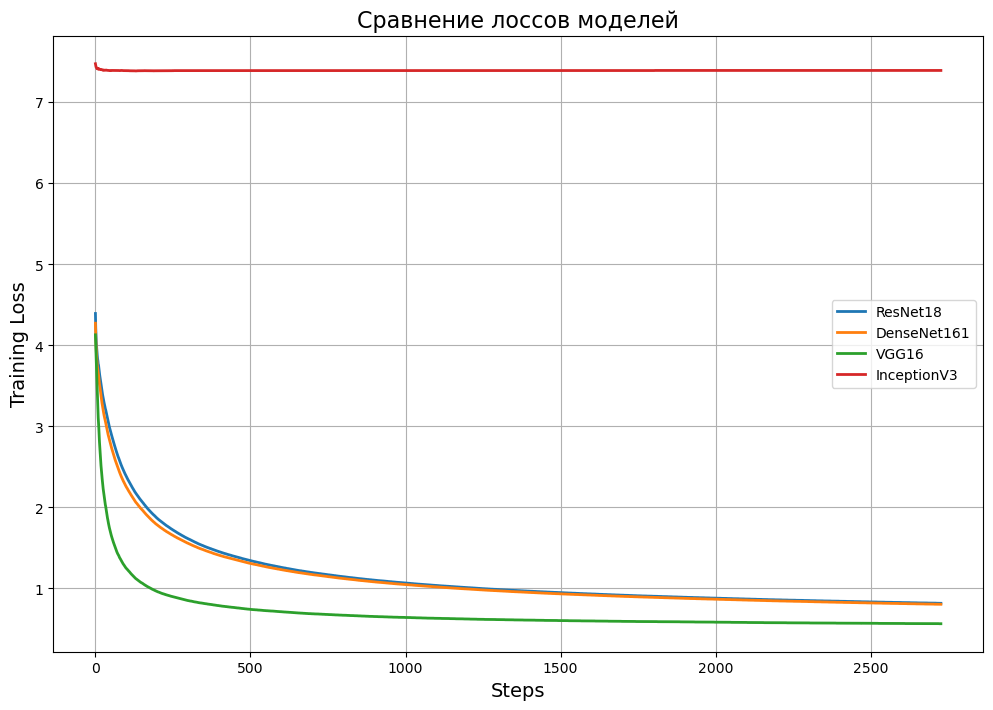

In [44]:
plt.figure(figsize=(12, 8))

plt.plot(res_losses, label='ResNet18', linewidth=2)
plt.plot(dense_losses, label='DenseNet161', linewidth=2)
plt.plot(vgg_losses, label='VGG16', linewidth=2)
plt.plot(inception_losses, label='InceptionV3', linewidth=2)

plt.title('Сравнение лоссов моделей', fontsize=16)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

In [45]:
import pandas as pd

results = {'Модель': ['DenseNet161', 'ResNet18', 'VGG16', 'Inception v3'], 'Test Accuracy': [0.806, 0.802, 0.855, 0.013]}
df_results = pd.DataFrame(results)
df_results

,Модель,Test Accuracy
0,DenseNet161,0.806
1,ResNet18,0.802
2,VGG16,0.855
3,Inception v3,0.013
